In [ ]:
# !pip install pyspark
# from google.colab import drive
# drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 37.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=914b67b6d3b76e22b248ea7992a66b5369ec07e0d349c577c20d55b9b69297b9
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Mounted at /content/drive


In [ ]:
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark import SparkContext


import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import PorterStemmer
from nltk.corpus import stopwords

#from nltk.grammar import Nonterminal

import pandas as pd
import numpy as np

import imblearn
from imblearn.metrics import geometric_mean_score

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score,f1_score,classification_report,confusion_matrix,roc_curve,precision_recall_curve,auc,precision_recall_fscore_support, make_scorer
from sklearn.model_selection import cross_val_predict,train_test_split, cross_val_score

from joblib import parallel_backend

import matplotlib.pyplot as plt

import seaborn as sns

import gc

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

**EXPLORATION DES DONNEES**

Collecte des données et retraitement du dataframe:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
data = spark.read.csv('./pr_10k.csv', sep=';',header = True)
data = data.na.fill("NULLDATA")

In [ ]:
def preprocessing_data(df):
    regexp = RegexpTokenizer('\w+')
    stopwords = nltk.corpus.stopwords.words("english")
    wordnet_lem = WordNetLemmatizer()
    df = df.toPandas()
    stemmer = PorterStemmer()
    for col in df.columns:
        df[col] = df[col].astype(str).str.lower()
        
        #regex token :
        df[col]=df[col].apply(regexp.tokenize)
        
        #stop word :
        df[col] = df[col].apply(lambda x: [item for item in x if item not in stopwords])
        

        #lemmatization
        def lemmatize_words(text):
                wordnet_lem = WordNetLemmatizer()
                words = [wordnet_lem.lemmatize(word,pos='n') for word in text]
                words = [wordnet_lem.lemmatize(word,pos='v') for word in text]
                return ' '.join(words)
            
        df[col] = df[col].apply(lemmatize_words)


  
        
        final_df = spark.createDataFrame(df)
    return final_df

In [ ]:
df = preprocessing_data(data)

In [ ]:
df.show()

+--------------------+--------------------+---------+
|                name|              review|sentiment|
+--------------------+--------------------+---------+
|annas dream full ...|soft comfortable ...| positive|
|stop pacifier suc...|product well wort...| positive|
|stop pacifier suc...|kid cry non stop ...| positive|
|stop pacifier suc...|binky fairy come ...| positive|
|tale baby days pe...|lovely book bind ...| positive|
|baby tracker reg ...|perfect new paren...| positive|
|baby tracker reg ...|friend mine pin p...| positive|
|baby tracker reg ...|easy way nanny re...| positive|
|baby tracker reg ...|love journal nann...| positive|
|baby tracker reg ...|book perfect firs...| positive|
|baby tracker reg ...|originally give n...| positive|
|nature lullabies ...|space monthly pho...| positive|
|nature lullabies ...|buy calender seco...| positive|
|nature lullabies ...|love little calen...| positive|
|nature lullabies ...|calender could fi...| positive|
|nature lullabies ...|comple

Création RDD et utilisation de word count :

In [ ]:
rdd = df.rdd

In [ ]:
def wordcount(t): 
    t = t.flatMap(list)
    motsun = t.flatMap(lambda x: [(w,1) for  w in x.split() if len(w)>2 and w!='nulldata'])
    wc = motsun.reduceByKey(lambda x,y : x + y)
    return wc

In [ ]:
wordcount(rdd).take(20)

[('annas', 1),
 ('dream', 74),
 ('full', 296),
 ('quilt', 194),
 ('sham', 1),
 ('soft', 908),
 ('comfortable', 793),
 ('warmer', 938),
 ('look', 1398),
 ('fit', 1413),
 ('size', 871),
 ('bed', 598),
 ('perfectly', 297),
 ('would', 3571),
 ('recommend', 1688),
 ('anyone', 385),
 ('type', 198),
 ('positive', 7939),
 ('stop', 301),
 ('pacifier', 79)]

Requêtes SQL :

In [ ]:
req1 = data.groupBy("name","sentiment").count().where("sentiment=='positive'")
req1.show()

+--------------------+---------+-----+
|                name|sentiment|count|
+--------------------+---------+-----+
|Leachco Bath 'N B...| positive|   15|
|The First Years T...| positive|    6|
|All Stars 6 Piece...| positive|   11|
|Basic Comfort Han...| positive|    4|
|The First Years N...| positive|   24|
|Philips AVENT Inf...| positive|    5|
|Philips AVENT Dis...| positive|   10|
|Prince Lionheart ...| positive|    2|
|The First Years S...| positive|   39|
|Kel-Gar Stroll'r ...| positive|    5|
|Regal Lager Diape...| positive|    2|
|Fisher-Price Slum...| positive|    3|
|Safety 1st Deluxe...| positive|   48|
|Leachco Crib Spac...| positive|    1|
|         PureLan 100| positive|    2|
|PRIMO EuroBath, P...| positive|  162|
|Kidco, Inc. 5.5' ...| positive|    2|
|Evenflo Snugli Po...| positive|    1|
|Newborn 5 Piece S...| positive|    1|
|Semanario (7) Lit...| positive|    1|
+--------------------+---------+-----+
only showing top 20 rows



In [ ]:
req2_po = data.groupBy("name","sentiment").count().where("sentiment=='positive'")
req2_neg = data.groupBy("name","sentiment").count().where("sentiment=='negative'")
req2 = req2_po.join(req2_neg,on='name')
req2.show()

+--------------------+---------+-----+---------+-----+
|                name|sentiment|count|sentiment|count|
+--------------------+---------+-----+---------+-----+
|Playtex 3 Pack Ve...| positive|   62| negative|   23|
|Prince Lionheart ...| positive|    3| negative|    3|
|The First Years N...| positive|   24| negative|   18|
|Delta Children's ...| positive|    8| negative|    1|
|Seal 'n Go Breast...| positive|    3| negative|    1|
|Eddie Bauer Backp...| positive|    3| negative|    6|
|The First Years 4...| positive|   16| negative|    3|
|Philips AVENT New...| positive|   30| negative|   27|
|The First Years 2...| positive|    1| negative|    1|
|Sassy Baby Powder...| positive|    2| negative|    4|
|Sassy Baby Warmin...| positive|    5| negative|    1|
|Once Upon A Potty...| positive|    5| negative|    2|
|Dr. Brown's Natur...| positive|    2| negative|    2|
|Regalo Easy Diner...| positive|   79| negative|   22|
|NUK 2 Pack Classi...| positive|    4| negative|    1|
|Playtex D

In [ ]:
req3 = data.where("review=='NULLDATA'")
req3.show()

+--------------------+--------+---------+
|                name|  review|sentiment|
+--------------------+--------+---------+
|SoftPlay Twinkle ...|NULLDATA| positive|
|Our Baby Girl Mem...|NULLDATA| positive|
|Summer Infant, Ul...|NULLDATA| positive|
|Safety 1st Deluxe...|NULLDATA| negative|
|Northstate Supery...|NULLDATA| positive|
|Munchkin Mozart M...|NULLDATA| positive|
|Graco TotBloc Pac...|NULLDATA| positive|
|Graco TotBloc Pac...|NULLDATA| positive|
|Prince Lionheart ...|NULLDATA| negative|
|BABYBJORN Toilet ...|NULLDATA| positive|
|BABYBJORN Potty C...|NULLDATA| positive|
|DEX Products Preg...|NULLDATA| positive|
|DEX Products Preg...|NULLDATA| negative|
|Playtex 3 Pack BP...|NULLDATA| positive|
|The First Years B...|NULLDATA| negative|
|The First Years S...|NULLDATA| positive|
|  Sliding Door Locks|NULLDATA| negative|
|Graco - Duo Strol...|NULLDATA| positive|
|Prince Lionheart ...|NULLDATA| positive|
|Dr. Brown's Natur...|NULLDATA| negative|
+--------------------+--------+---

**ANALYSE DES SENTIMENTS**

Retraitement des données :

In [ ]:
data_ML = df.toPandas()
print("DF size: {:.0f}".format(len(data_ML)))
data_ML = data_ML[data_ML['review']!='nulldata']
print("DF without null data size: {:.0f}".format(len(data_ML)))

DF size: 9999
DF without null data size: 9976


In [ ]:
data_ML['sentiment'].replace(['positive','negative'],[int(1), int(0)], inplace=True)

Split des données en 2 jeux : 


*   Train : entrainement du jeu avec plusieurs paramètres
*   Test : test du modèle avec un jeu pas encore utilisé 

Stratify utilisé pour être sûr d'avoir la même compo de positif et negatif dans train et test. On pourrait également utiliser un dataset un peu réajusté (pas trop pour ne pas déformer la réalité, afin d'ajouter des valeurs random de la classe sous représentée. Les résultats sont meilleurs.



In [ ]:
X,y = data_ML.review, data_ML.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:

def metrics_df(model,X,y,y_pred,average="binary"):
  score = model.score(X,y_test)
  precision = precision_score(y, y_pred,average=average)
  recall = recall_score(y, y_pred,average=average)
  f_score = f1_score(y, y_pred,average=average)
  df = pd.Series({"Score (not really usefull for unbalanced dataset)":score,"Precision":precision, "Recall":recall,"F1 Score":f_score})
  return df

def confusion_matrix_plot(model, X, y, y_pred):
  cm=confusion_matrix(y, y_pred)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(model.score(X,y))
  plt.title(all_sample_title, size = 15);
  plt.show();

def plot_precision_recall_vs_thresholds(model, X ,y, method):
  y_scores=cross_val_predict(model, X, y, cv=3, method=method)
  if method == "predict_proba":
    precisions, recalls, thresholds = precision_recall_curve(y , y_scores[:,1])
  else:
    precisions, recalls, thresholds = precision_recall_curve(y , y_scores)
  plt.plot(thresholds, precisions[:-1],"b--", label="Precision",linewidth=2)
  plt.plot(thresholds, recalls[:-1],"g--", label="Recall",linewidth=2)
  plt.xlabel("Threshold",fontsize =16)
  plt.legend(loc="lower left",fontsize=16)
  plt.ylim([0,1])

def plot_roc_curve(model, X ,y, method, label=None):
  y_scores=cross_val_predict(model, X, y, cv=3, method=method)
  if method == "predict_proba":
    fpr,tpr,thresholds = roc_curve(y,y_scores[:,1])
  else :
    fpr,tpr,thresholds = roc_curve(y,y_scores)
  auc_value = auc(fpr,tpr)
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.title("AUC : {:.2f}".format(auc_value))
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('FPR',fontsize=16)
  plt.ylabel('TPR',fontsize=16)


SVM Model :

*Choice 1 : CountVectorizer*

In [ ]:
gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True) #Gmean is the sqrt(sensitiviy*specificity) and is often used for imbalanced data

pipe = make_pipeline(CountVectorizer(), LinearSVC(max_iter=8000))
param_grid = {'linearsvc__C':[0.001,0.005, 0.1],
              'linearsvc__penalty': ['l2'],
              'linearsvc__loss': ['squared_hinge'],
              'linearsvc__class_weight':['balanced'],
              'countvectorizer__ngram_range': [(1, 2),(1,3)],
              'countvectorizer__min_df':[4,5,6,7]}

grid_countvec_svc = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring='roc_auc') 

with parallel_backend('threading', n_jobs=4):
  grid_countvec_svc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

210

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_countvec_svc.best_score_))
print("Best parameters: ", grid_countvec_svc.best_params_)


Best cross-validation score: 0.92
Best parameters:  {'countvectorizer__min_df': 4, 'countvectorizer__ngram_range': (1, 3), 'linearsvc__C': 0.005, 'linearsvc__class_weight': 'balanced', 'linearsvc__loss': 'squared_hinge', 'linearsvc__penalty': 'l2'}


In [ ]:
countvec_svc = grid_countvec_svc.best_estimator_.named_steps["countvectorizer"]
countvec_svc_best = grid_countvec_svc.best_estimator_.named_steps["linearsvc"]
X_test_countvec_svc_best=countvec_svc.transform(X_test)
y_pred_countvec_svc_best = cross_val_predict(countvec_svc_best,X_test_countvec_svc_best,y_test,cv=5)

In [ ]:
metrics_df(countvec_svc_best,X_test_countvec_svc_best,y_test,y_pred_countvec_svc_best)

Score (not really usefull for unbalanced dataset)    0.870489
Precision                                            0.919397
Recall                                               0.898831
F1 Score                                             0.908997
dtype: float64

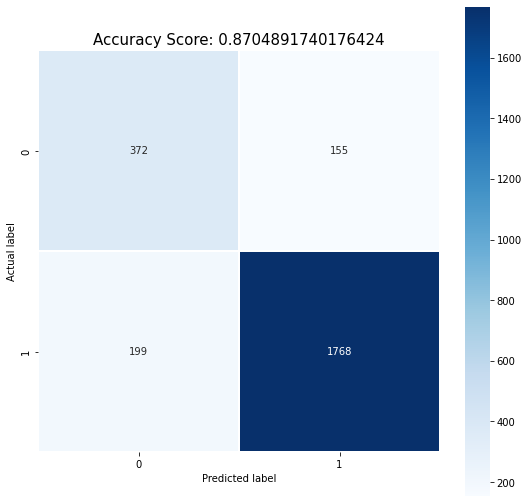

In [ ]:
confusion_matrix_plot(countvec_svc_best,X_test_countvec_svc_best,y_test, y_pred_countvec_svc_best)

In [ ]:
print(classification_report(y_test,y_pred_countvec_svc_best))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       527
           1       0.92      0.90      0.91      1967

    accuracy                           0.86      2494
   macro avg       0.79      0.80      0.79      2494
weighted avg       0.86      0.86      0.86      2494



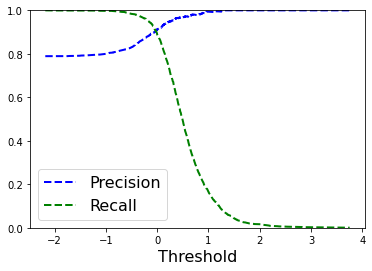

In [ ]:
plot_precision_recall_vs_thresholds(countvec_svc_best, X_test_countvec_svc_best,y_test,"decision_function")

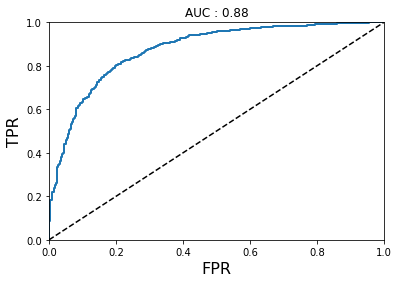

In [ ]:
plot_roc_curve(countvec_svc_best, X_test_countvec_svc_best,y_test,"decision_function")

*Choice 2 : TFIDFVectorizer*

In [ ]:
pipe = make_pipeline(TfidfVectorizer(), LinearSVC(max_iter=6000))
param_grid = {'linearsvc__C': [0.5,1,5],
              'linearsvc__penalty': ['l2'],
              'linearsvc__loss': ['squared_hinge'],
              'linearsvc__class_weight':['balanced'],
              'tfidfvectorizer__ngram_range': [(1, 2),(1,3)],
              'tfidfvectorizer__min_df':[4,5,6,7]}

grid_tfidfvec_svc = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring='roc_auc')

with parallel_backend('threading', n_jobs=4):
  grid_tfidfvec_svc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

9015

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_tfidfvec_svc.best_score_))
print("Best parameters: ", grid_tfidfvec_svc.best_params_)

Best cross-validation score: 0.93
Best parameters:  {'linearsvc__C': 0.5, 'linearsvc__class_weight': 'balanced', 'linearsvc__loss': 'squared_hinge', 'linearsvc__penalty': 'l2', 'tfidfvectorizer__min_df': 4, 'tfidfvectorizer__ngram_range': (1, 3)}


In [ ]:
tfidfvec_svc = grid_tfidfvec_svc.best_estimator_.named_steps["tfidfvectorizer"]
tfidfvec_svc_best = grid_tfidfvec_svc.best_estimator_.named_steps["linearsvc"]
X_test_tfidfvec_svc_best=tfidfvec_svc.transform(X_test)
y_pred_tfidfvec_svc_best = cross_val_predict(tfidfvec_svc_best,X_test_tfidfvec_svc_best,y_test,cv=5)

In [ ]:
metrics_df(tfidfvec_svc_best,X_test_tfidfvec_svc_best,y_test,y_pred_tfidfvec_svc_best)

Score (not really usefull for unbalanced dataset)    0.888132
Precision                                            0.905651
Recall                                               0.936960
F1 Score                                             0.921039
dtype: float64

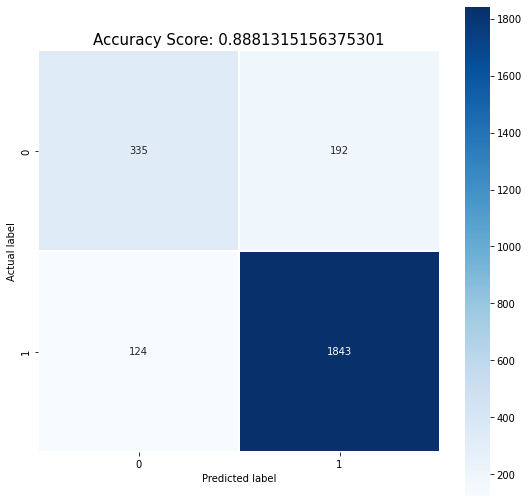

In [ ]:
confusion_matrix_plot(tfidfvec_svc_best,X_test_tfidfvec_svc_best,y_test, y_pred_tfidfvec_svc_best)

In [ ]:
print(classification_report(y_test,y_pred_tfidfvec_svc_best))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       527
           1       0.91      0.94      0.92      1967

    accuracy                           0.87      2494
   macro avg       0.82      0.79      0.80      2494
weighted avg       0.87      0.87      0.87      2494



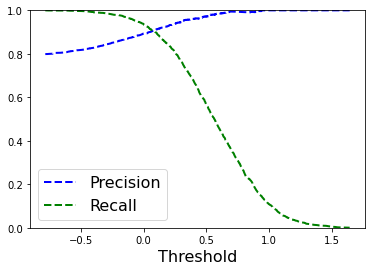

In [ ]:
plot_precision_recall_vs_thresholds(tfidfvec_svc_best,X_test_tfidfvec_svc_best,y_test,"decision_function")

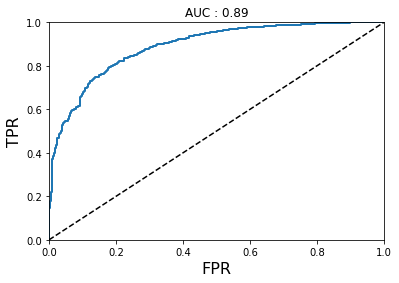

In [ ]:
plot_roc_curve(tfidfvec_svc_best,X_test_tfidfvec_svc_best,y_test,"decision_function")

**LOGISTIC REGRESSION**

*Choice 1 : CountVectorizer*

In [ ]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [2,3,4],
              'logisticregression__penalty': ['l2'],
              'logisticregression__class_weight': ['Balanced'],
              'countvectorizer__ngram_range': [(1, 2),(1,3)],
              'countvectorizer__min_df':[4,5,6,7]}

grid_countvec_LR = GridSearchCV(pipe, param_grid, cv=5,verbose=1, scoring='roc_auc')

with parallel_backend('threading', n_jobs=4):
  grid_countvec_LR.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

11723

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_countvec_LR.best_score_))
print("Best parameters: ", grid_countvec_LR.best_params_)

Best cross-validation score: 0.91
Best parameters:  {'countvectorizer__min_df': 4, 'countvectorizer__ngram_range': (1, 3), 'logisticregression__C': 2, 'logisticregression__class_weight': 'Balanced', 'logisticregression__penalty': 'l2'}


In [ ]:
countvec_LR = grid_countvec_LR.best_estimator_.named_steps["countvectorizer"]
countvec_logreg_best = grid_countvec_LR.best_estimator_.named_steps["logisticregression"]
X_test_countvec_LR_best=countvec_LR.transform(X_test)
y_pred_countvec_LR_best = cross_val_predict(countvec_logreg_best,X_test_countvec_LR_best,y_test,cv=5)

In [ ]:
metrics_df(countvec_logreg_best,X_test_countvec_LR_best,y_test,y_pred_countvec_LR_best)

Score (not really usefull for unbalanced dataset)    0.891339
Precision                                            0.887571
Recall                                               0.951195
F1 Score                                             0.918282
dtype: float64

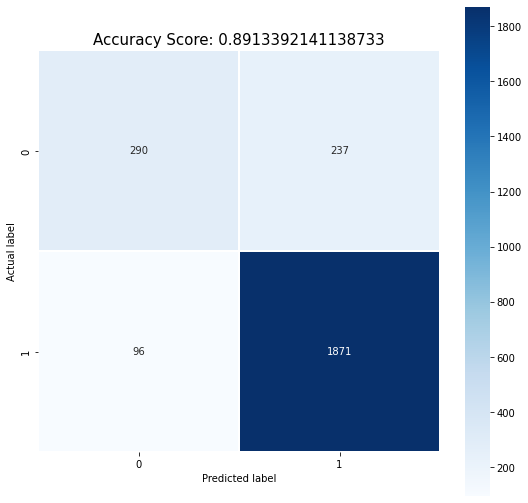

In [ ]:
confusion_matrix_plot(countvec_logreg_best,X_test_countvec_LR_best,y_test, y_pred_countvec_LR_best)

In [ ]:
print(classification_report(y_test,y_pred_countvec_LR_best))

              precision    recall  f1-score   support

           0       0.75      0.55      0.64       527
           1       0.89      0.95      0.92      1967

    accuracy                           0.87      2494
   macro avg       0.82      0.75      0.78      2494
weighted avg       0.86      0.87      0.86      2494



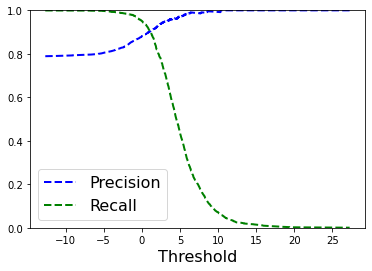

In [ ]:
plot_precision_recall_vs_thresholds(countvec_logreg_best, X_test_countvec_LR_best,y_test,"decision_function")

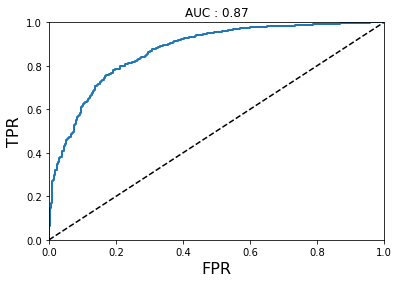

In [ ]:
plot_roc_curve(countvec_logreg_best, X_test_countvec_LR_best,y_test,"decision_function")

*Choice 2 TFIDF Vectorizer*

In [ ]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [5,10,20],
              'logisticregression__penalty': ['l2'],
              'logisticregression__class_weight': ['balanced'],
              'tfidfvectorizer__ngram_range': [(1, 2),(1,3)],
              'tfidfvectorizer__min_df':[4,5,6,7]}

grid_tfidfvec_LR = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring='roc_auc')

with parallel_backend('threading', n_jobs=4):
  grid_tfidfvec_LR.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

12298

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_tfidfvec_LR.best_score_))
print("Best parameters: ", grid_tfidfvec_LR.best_params_)

Best cross-validation score: 0.93
Best parameters:  {'logisticregression__C': 5, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'tfidfvectorizer__min_df': 4, 'tfidfvectorizer__ngram_range': (1, 3)}


In [ ]:
tfidfvec_LR = grid_tfidfvec_LR.best_estimator_.named_steps["tfidfvectorizer"]
tfidfvec_LR_best = grid_tfidfvec_LR.best_estimator_.named_steps["logisticregression"]
X_test_tfidfvec_LR_best=tfidfvec_LR.transform(X_test)
y_pred_tfidfvec_LR_best = cross_val_predict(tfidfvec_LR_best,X_test_tfidfvec_LR_best,y_test,cv=5)

In [ ]:
metrics_df(tfidfvec_LR_best,X_test_tfidfvec_LR_best,y_test,y_pred_tfidfvec_LR_best)

Score (not really usefull for unbalanced dataset)    0.884924
Precision                                            0.907526
Recall                                               0.937977
F1 Score                                             0.922500
dtype: float64

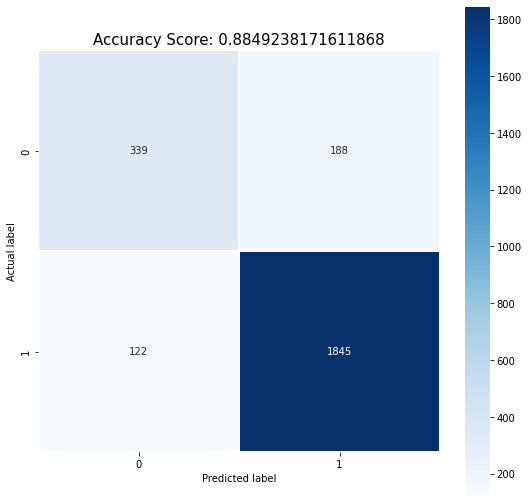

In [ ]:
confusion_matrix_plot(tfidfvec_LR_best,X_test_tfidfvec_LR_best,y_test, y_pred_tfidfvec_LR_best)

In [ ]:
print(classification_report(y_test,y_pred_tfidfvec_LR_best))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       527
           1       0.91      0.94      0.92      1967

    accuracy                           0.88      2494
   macro avg       0.82      0.79      0.80      2494
weighted avg       0.87      0.88      0.87      2494



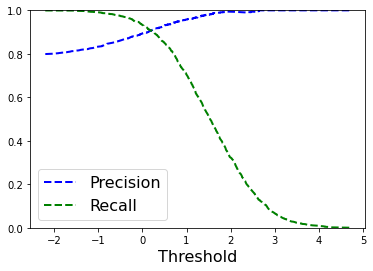

In [ ]:
plot_precision_recall_vs_thresholds(tfidfvec_LR_best,X_test_tfidfvec_LR_best,y_test,"decision_function")

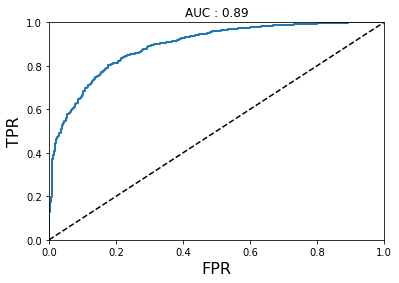

In [ ]:
plot_roc_curve(tfidfvec_LR_best,X_test_tfidfvec_LR_best,y_test,"decision_function")

**BERNOULLI NB**

*Count Vectorizer*

In [ ]:
pipe = make_pipeline(CountVectorizer(), BernoulliNB())
param_grid = {'bernoullinb__alpha': [0.01,0.05,0.1],
              'countvectorizer__ngram_range': [(1, 2),(1,3)],
              'countvectorizer__min_df':[4,5,6,7]}

grid_countvec_NB = GridSearchCV(pipe, param_grid, cv=5, verbose=1,scoring='roc_auc')

with parallel_backend('threading', n_jobs=4):
  grid_countvec_NB.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

9588

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_countvec_NB.best_score_))
print("Best parameters: ", grid_countvec_NB.best_params_)

Best cross-validation score: 0.91
Best parameters:  {'bernoullinb__alpha': 0.1, 'countvectorizer__min_df': 4, 'countvectorizer__ngram_range': (1, 3)}


In [ ]:
countvec_NB = grid_countvec_NB.best_estimator_.named_steps["countvectorizer"]
countvec_NB_best = grid_countvec_NB.best_estimator_.named_steps["bernoullinb"]
X_test_countvec_NB_best=countvec_NB.transform(X_test)
y_pred_countvec_NB_best = cross_val_predict(countvec_NB_best,X_test_countvec_NB_best,y_test,cv=5)

In [ ]:
metrics_df(countvec_NB_best,X_test_countvec_NB_best,y_test,y_pred_countvec_NB_best)

Score (not really usefull for unbalanced dataset)    0.879310
Precision                                            0.883430
Recall                                               0.932384
F1 Score                                             0.907247
dtype: float64

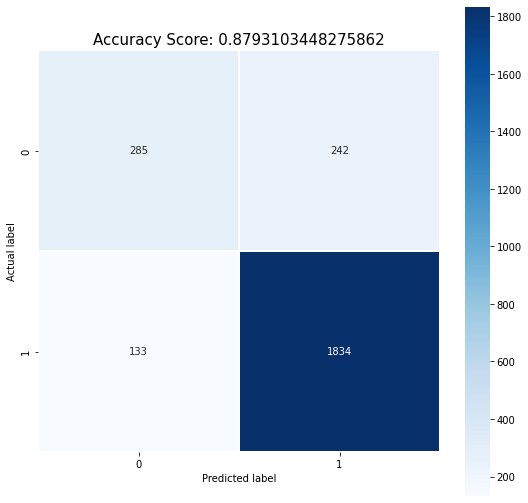

In [ ]:
confusion_matrix_plot(countvec_NB_best,X_test_countvec_NB_best,y_test,y_pred_countvec_NB_best)

In [ ]:
print(classification_report(y_test,y_pred_countvec_NB_best))

              precision    recall  f1-score   support

           0       0.68      0.54      0.60       527
           1       0.88      0.93      0.91      1967

    accuracy                           0.85      2494
   macro avg       0.78      0.74      0.76      2494
weighted avg       0.84      0.85      0.84      2494



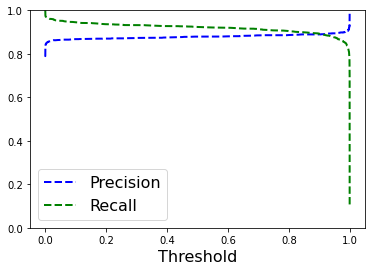

In [ ]:
plot_precision_recall_vs_thresholds(countvec_NB_best,X_test_countvec_NB_best,y_test,"predict_proba")

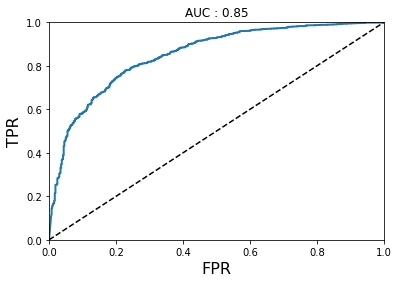

In [ ]:
plot_roc_curve(countvec_NB_best,X_test_countvec_NB_best,y_test,"predict_proba")

*TFIDF Vectorizer*

In [ ]:
pipe = make_pipeline(TfidfVectorizer(), BernoulliNB())
param_grid = {'bernoullinb__alpha': [0.01,0.05,0.1],
              'tfidfvectorizer__ngram_range': [(1, 2),(1,3)],
              'tfidfvectorizer__min_df':[4,5,6,7]}

grid_tfidf_NB = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring='roc_auc')

with parallel_backend('threading', n_jobs=4):
  grid_tfidf_NB.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
gc.collect()

9024

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_tfidf_NB.best_score_))
print("Best parameters: ", grid_tfidf_NB.best_params_)

Best cross-validation score: 0.91
Best parameters:  {'bernoullinb__alpha': 0.1, 'tfidfvectorizer__min_df': 4, 'tfidfvectorizer__ngram_range': (1, 3)}


In [ ]:
tfidfvec_NB = grid_tfidf_NB.best_estimator_.named_steps["tfidfvectorizer"]
tfidfvec_NB_best = grid_tfidf_NB.best_estimator_.named_steps["bernoullinb"]
X_test_tfidfvec_NB_best=tfidfvec_NB.transform(X_test)
y_pred_tfidfvec_NB_best = cross_val_predict(tfidfvec_NB_best,X_test_tfidfvec_NB_best,y_test,cv=5)

In [ ]:
metrics_df(tfidfvec_NB_best,X_test_tfidfvec_NB_best,y_test,y_pred_tfidfvec_NB_best)

Score (not really usefull for unbalanced dataset)    0.879310
Precision                                            0.883430
Recall                                               0.932384
F1 Score                                             0.907247
dtype: float64

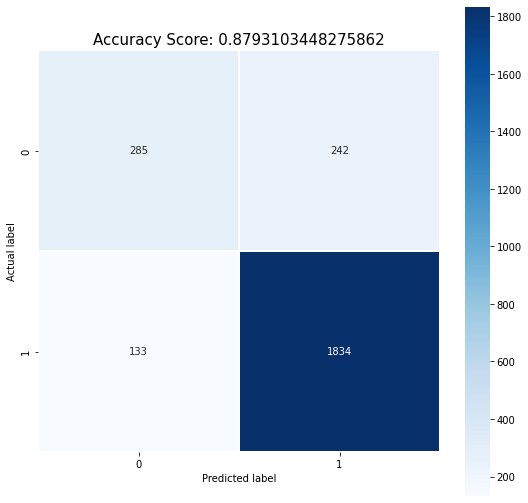

In [ ]:
confusion_matrix_plot(tfidfvec_NB_best,X_test_tfidfvec_NB_best,y_test,y_pred_tfidfvec_NB_best)

In [ ]:
print(classification_report(y_test,y_pred_tfidfvec_NB_best))

              precision    recall  f1-score   support

           0       0.68      0.54      0.60       527
           1       0.88      0.93      0.91      1967

    accuracy                           0.85      2494
   macro avg       0.78      0.74      0.76      2494
weighted avg       0.84      0.85      0.84      2494



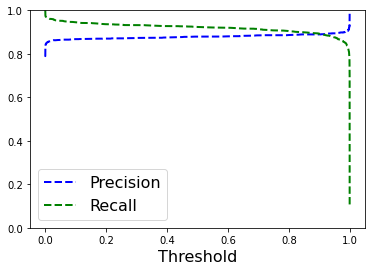

In [ ]:
plot_precision_recall_vs_thresholds(tfidfvec_NB_best,X_test_tfidfvec_NB_best,y_test,"predict_proba")

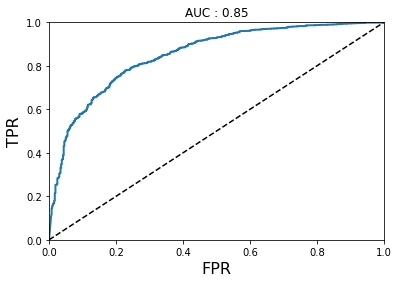

In [ ]:
plot_roc_curve(tfidfvec_NB_best,X_test_tfidfvec_NB_best,y_test,"predict_proba")

**Synthèse :**

Sur les 3 modèles testés, le choix se porte sur la Logistic Regression avec TFIDF car elle offre le meilleur compromis precision recall ainsi que le meilleur AUC, métrique que j'ai privilégié pour ce type de dataset.

**MLP Classifier**
(Not used for now, need to adjust parameters in a better way)

*choice 1 : CountVectorizer*

In [ ]:
#@title
pipe = make_pipeline(CountVectorizer(), MLPClassifier(activation='logistic', max_iter=1000))
param_grid = {'mlpclassifier__hidden_layer_sizes': [[5,4,5],[5,5,5],[5,6,5]],
              'countvectorizer__ngram_range': [(1, 2),(1,3)],
              'countvectorizer__min_df':[4,5,6,7]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

with parallel_backend('threading', n_jobs=4):
  grid.fit(X_train, y_train)

In [ ]:
#@title
gc.collect()

In [ ]:
#@title
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

In [ ]:
#@title
vec = grid.best_estimator_.named_steps["countvectorizer"]
MLP_best = grid.best_estimator_.named_steps["mlpclassifier"]
X_test_vec=vec.transform(X_test)
y_pred = cross_val_predict(NB_best,X_test_vec,y_test,cv=5)

In [ ]:
#@title
metrics_df(MLP_best,X_test_vec,y_test,y_pred)

In [ ]:
#@title
confusion_matrix_plot(MLP_best,X_test_vec,y_test, y_pred)

In [ ]:
#@title
print(classification_report(y_test,y_pred))

In [ ]:
#@title
plot_precision_recall_vs_thresholds(MLP_best, X_test_vec,y_test,"predict_proba")

In [ ]:
#@title
plot_roc_curve(MLP_best, X_test_vec, y_test,"predict_proba")

*Choice 2 : TFIDFVectorizer*

In [ ]:
#@title
pipe = make_pipeline(TfidfVectorizer(), MLPClassifier(activation='logistic', max_iter=1000))
param_grid = {'mlpclassifier__hidden_layer_sizes': [[5,4,5],[5,5,5],[5,6,5]],
              'tfidfvectorizer__ngram_range': [(1, 2),(1,3)],
              'tfidfvectorizer__min_df':[4,5,6,7]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

with parallel_backend('threading', n_jobs=4):
  grid.fit(X_train, y_train)

In [ ]:
#@title
gc.collect()

In [ ]:
#@title
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

In [ ]:
#@title
vec = grid.best_estimator_.named_steps["tfidfvectorizer"]
MLP_best = grid.best_estimator_.named_steps["mlpclassifier"]
X_test_vec=vec.transform(X_test)
y_pred = cross_val_predict(NB_best,X_test_vec,y_test,cv=5)

In [ ]:
#@title
confusion_matrix_plot(MLP_best,X_test_vec,y_test, y_pred)

In [ ]:
#@title
print(classification_report(y_test,y_pred))

In [ ]:
#@title
plot_precision_recall_vs_thresholds(MLP_best, X_test_vec,y_test,"predict_proba")

In [ ]:
#@title
plot_roc_curve(MLP_best, X_test_vec, y_test,"predict_proba")